Loading embeddings from: ./embeddings/final_embeddings_molecules_20250308_221455.pkl
Loaded 41 embeddings
Rebuilding molecules from graph data...
Successfully rebuilt 41 molecules
Reducing dimensionality...


C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Calculating molecular weights...
Selecting diverse molecules for visualization...
Creating embedding visualization with markers...


C:\Users\Malli\AppData\Local\Temp\ipykernel_11940\736239607.py:251: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x, y), 0.3, fill=True, color='white', edgecolor='black', zorder=10)


Visualization saved to: ./visualization_files\embedding_with_markers.png
Saving molecule information for Step 2...
Saved molecule information to ./visualization_files\selected_molecules.json
Step 1 complete! Now run the molecule rendering script (Step 2).


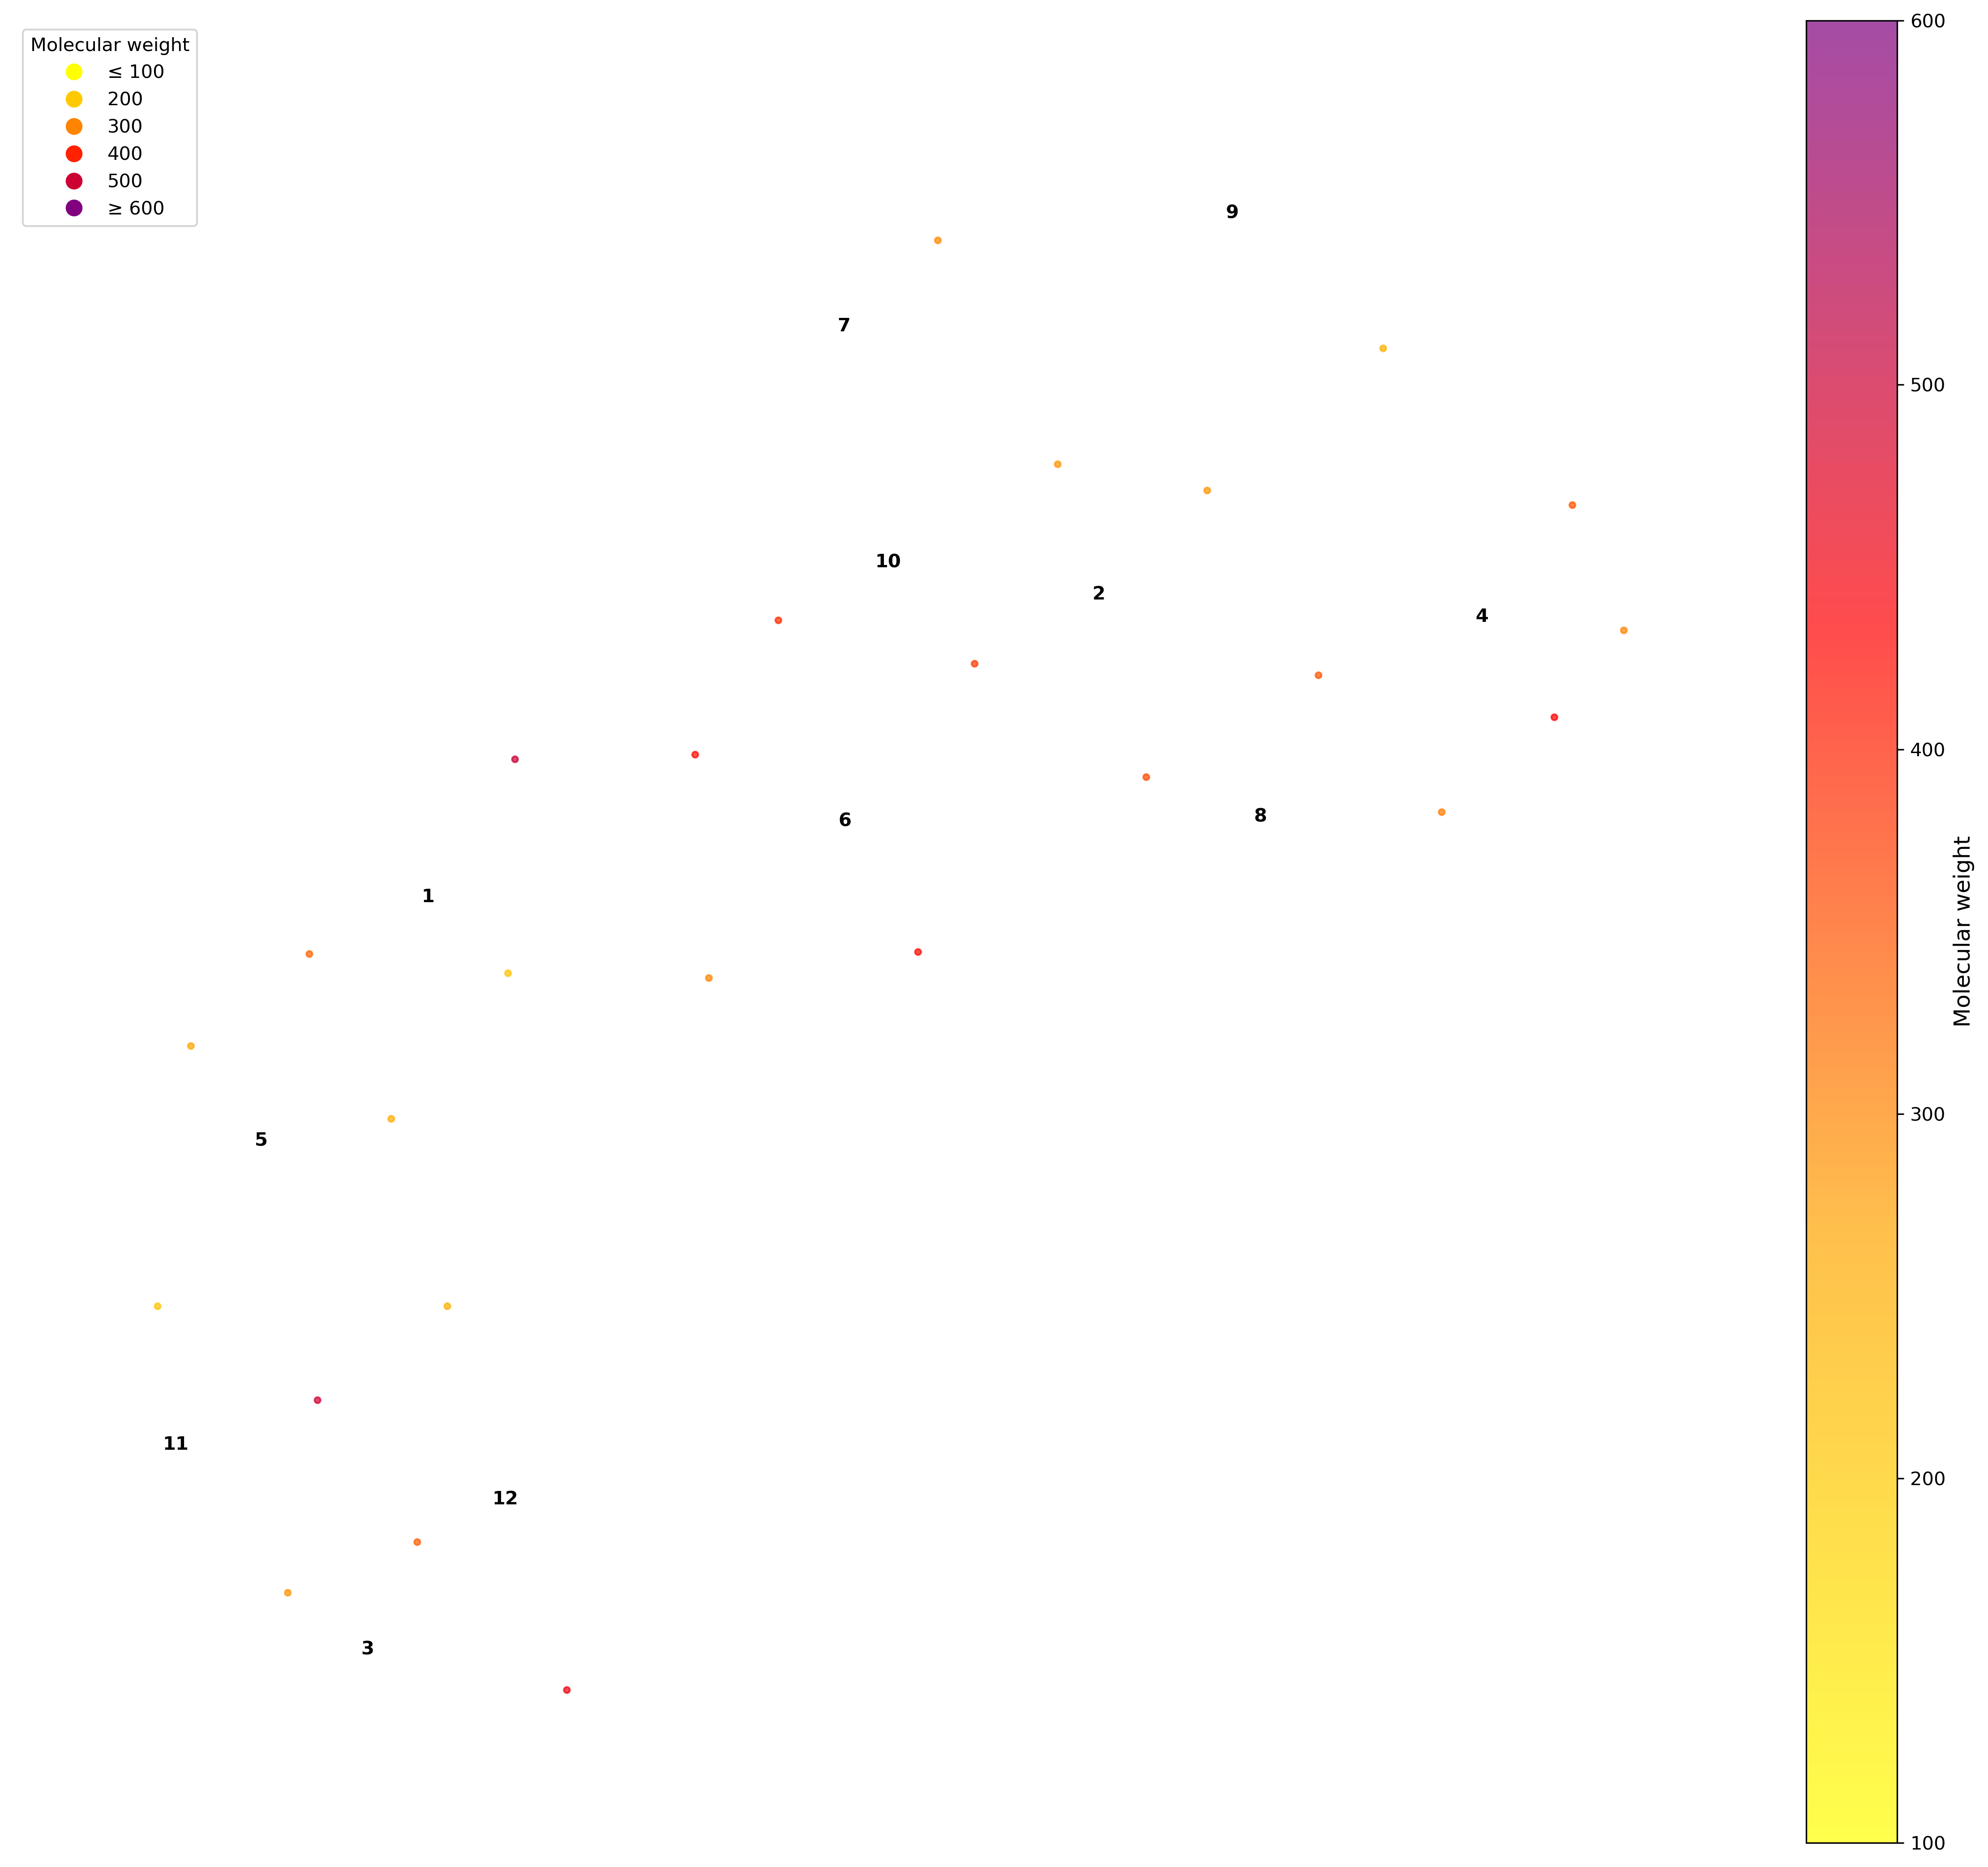

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import umap
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
import json
from sklearn.cluster import KMeans
from scipy.spatial import distance
from matplotlib.lines import Line2D
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

def load_embeddings(filepath):
    """Load embeddings and molecule data from file"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = data['embeddings']
    molecule_data = data.get('molecule_data', None)
    
    return embeddings, molecule_data

def reduce_dimensions(embeddings, method='umap', n_components=2, **kwargs):
    """Reduce dimensionality of embeddings for visualization"""
    if method.lower() == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'umap':
        import umap
        reducer = umap.UMAP(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'pca':
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=n_components, **kwargs)
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

def rebuild_molecules_from_graph_data(molecule_data_list):
    """Reconstruct RDKit molecules from graph data - simplified version"""
    # Maps for atom and bond features
    atom_list = list(range(1, 119))
    bond_list = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE, 
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ]
    
    molecules = []
    valid_count = 0
    
    for i, mol_data in enumerate(molecule_data_list):
        try:
            # Create empty editable molecule
            mol = Chem.RWMol()
            
            # Add atoms based on x_cat data
            x_cat = mol_data.get('x_cat')
            if x_cat is None:
                molecules.append(None)
                continue
                
            for atom_features in x_cat:
                atomic_num = atom_list[atom_features[0]]
                atom = Chem.Atom(atomic_num)
                mol.AddAtom(atom)
            
            # Add bonds based on edge_index and edge_attr
            edge_index = mol_data.get('edge_index')
            edge_attr = mol_data.get('edge_attr')
            
            if edge_index is None or edge_attr is None:
                molecules.append(None)
                continue
                
            # Process only in one direction (undirected edges appear twice)
            processed_edges = set()
            
            for i in range(len(edge_index[0])):
                start, end = edge_index[0][i], edge_index[1][i]
                if start >= mol.GetNumAtoms() or end >= mol.GetNumAtoms():
                    continue
                if (start, end) in processed_edges or (end, start) in processed_edges:
                    continue
                    
                # Add the bond
                try:
                    bond_type_idx = int(edge_attr[i][0])
                    if bond_type_idx < len(bond_list):
                        bond_type = bond_list[bond_type_idx]
                        mol.AddBond(start, end, bond_type)
                        processed_edges.add((start, end))
                except Exception:
                    continue
            
            # Convert to molecule
            try:
                final_mol = Chem.Mol(mol)
                for atom in final_mol.GetAtoms():
                    atom.UpdatePropertyCache(strict=False)
                
                # Try to sanitize with error catching
                try:
                    Chem.SanitizeMol(final_mol)
                except:
                    pass
                    
                molecules.append(final_mol)
                valid_count += 1
            except Exception:
                molecules.append(None)
                
        except Exception:
            molecules.append(None)
    
    print(f"Successfully rebuilt {valid_count} molecules")
    return molecules

def create_molecular_weight_colormap():
    """Create a custom colormap similar to the reference image"""
    # Define the colors from light yellow to dark red/purple
    colors = [
        (1.0, 1.0, 0.0),      # light yellow
        (1.0, 0.65, 0.0),     # orange
        (1.0, 0.0, 0.0),      # red
        (0.5, 0.0, 0.5)       # purple
    ]
    
    # Create colormap
    cmap = LinearSegmentedColormap.from_list("molecular_weight", colors)
    return cmap

def calculate_molecular_weights(molecules):
    """Calculate molecular weights for valid molecules"""
    weights = []
    for mol in molecules:
        if mol is None:
            weights.append(0)
        else:
            try:
                weights.append(Descriptors.MolWt(mol))
            except:
                weights.append(0)
    return np.array(weights)

def get_smiles_for_molecules(molecules):
    """Extract SMILES strings for valid molecules"""
    smiles_list = []
    for mol in molecules:
        if mol is None:
            smiles_list.append(None)
        else:
            try:
                smiles = Chem.MolToSmiles(mol)
                smiles_list.append(smiles)
            except:
                smiles_list.append(None)
    return smiles_list

def select_diverse_molecules(embeddings_2d, molecules, n_samples=12):
    """Select diverse molecules using clustering"""
    # Filter out positions with invalid molecules
    valid_indices = [i for i, mol in enumerate(molecules) if mol is not None]
    valid_positions = embeddings_2d[valid_indices]
    
    # Skip if not enough valid molecules
    if len(valid_positions) < n_samples:
        print("Warning: Not enough valid molecules")
        return valid_indices[:n_samples]
    
    # Use KMeans to find diverse points
    kmeans = KMeans(n_clusters=n_samples, random_state=42, n_init=10)
    kmeans.fit(valid_positions)
    
    # Find the points closest to each cluster center
    centers = kmeans.cluster_centers_
    selected_indices = []
    
    for center in centers:
        distances = distance.cdist([center], valid_positions)[0]
        closest_idx = valid_indices[np.argmin(distances)]
        selected_indices.append(closest_idx)
    
    return selected_indices

def visualize_embedding_with_markers(
    embeddings_2d, 
    molecules, 
    weights, 
    selected_indices, 
    figsize=(16, 14), 
    dpi=300, 
    save_path=None
):
    """Create embedding visualization with numbered markers for selected molecules"""
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi, facecolor='white')
    
    # Create colormap
    cmap = create_molecular_weight_colormap()
    
    # Plot points
    scatter = ax.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=weights,
        cmap=cmap,
        alpha=0.7,
        s=10,
        vmin=100,
        vmax=600
    )
    
    # Create custom legend for molecular weight
    weight_values = [100, 200, 300, 400, 500, 600]
    
    legend_elements = []
    for weight in weight_values:
        if weight == 100:
            label = '≤ 100'
        elif weight == 600:
            label = '≥ 600' 
        else:
            label = f'{weight}'
            
        color = cmap((weight - 100) / 500)
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                   markersize=10, label=label)
        )
    
    # Add legend
    ax.legend(
        handles=legend_elements,
        title='Molecular weight',
        loc='upper left',
        frameon=True,
        fontsize=10
    )
    
    # Highlight selected points with numbered circles
    for i, idx in enumerate(selected_indices):
        x, y = embeddings_2d[idx]
        circle = plt.Circle((x, y), 0.3, fill=True, color='white', edgecolor='black', zorder=10)
        ax.add_patch(circle)
        ax.text(x, y, str(i+1), ha='center', va='center', color='black', fontweight='bold', zorder=11)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Molecular weight', fontsize=12)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove border
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Visualization saved to: {save_path}")
    
    return fig

def save_molecule_info(molecules, selected_indices, embeddings_2d, filename):
    """Save information about selected molecules for Step 2"""
    info = []
    
    for i, idx in enumerate(selected_indices):
        if idx >= len(molecules) or molecules[idx] is None:
            continue
            
        mol = molecules[idx]
        try:
            smiles = Chem.MolToSmiles(mol)
            position = embeddings_2d[idx].tolist()
            mol_weight = Descriptors.MolWt(mol)
            
            info.append({
                "index": i + 1,  # 1-based index for the markers
                "molecule_idx": int(idx),
                "smiles": smiles,
                "position": position,
                "weight": float(mol_weight)
            })
        except:
            continue
    
    # Save to JSON file
    with open(filename, 'w') as f:
        json.dump(info, f, indent=2)
    
    print(f"Saved molecule information to {filename}")
    
    return info

def main():
    # Create output directories
    output_dir = './visualization_files'
    os.makedirs(output_dir, exist_ok=True)
    
    # Try to load embeddings (update path to your file)
    embeddings_path = './embeddings/final_embeddings_molecules_20250308_221455.pkl'
    
    try:
        print(f"Loading embeddings from: {embeddings_path}")
        embeddings, molecule_data = load_embeddings(embeddings_path)
        print(f"Loaded {len(embeddings)} embeddings")
        
        # Rebuild molecules
        print("Rebuilding molecules from graph data...")
        molecules = rebuild_molecules_from_graph_data(molecule_data)
        
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Please provide a valid embeddings file path")
        return
    
    # Reduce dimensions for visualization
    print("Reducing dimensionality...")
    try:
        embeddings_2d = reduce_dimensions(
            embeddings, 
            method='umap',
            n_neighbors=30,
            min_dist=0.1,
            metric='cosine'
        )
    except Exception as e:
        print(f"Error with UMAP: {e}")
        print("Falling back to PCA...")
        embeddings_2d = reduce_dimensions(embeddings, method='pca')
    
    # Calculate molecular weights
    print("Calculating molecular weights...")
    weights = calculate_molecular_weights(molecules)
    
    # Select diverse molecules
    print("Selecting diverse molecules for visualization...")
    selected_indices = select_diverse_molecules(embeddings_2d, molecules, n_samples=12)
    
    # Create and save embedding visualization with markers
    print("Creating embedding visualization with markers...")
    fig = visualize_embedding_with_markers(
        embeddings_2d,
        molecules,
        weights,
        selected_indices,
        figsize=(16, 14),
        dpi=300,
        save_path=os.path.join(output_dir, 'embedding_with_markers.png')
    )
    
    # Save molecule information for Step 2
    print("Saving molecule information for Step 2...")
    molecule_info = save_molecule_info(
        molecules,
        selected_indices,
        embeddings_2d,
        os.path.join(output_dir, 'selected_molecules.json')
    )
    
    print("Step 1 complete! Now run the molecule rendering script (Step 2).")

if __name__ == "__main__":
    main()